<a href="https://colab.research.google.com/github/leoserpa/Rossmann_Stores/blob/main/m010_v01_store_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Imports

In [ ]:
import math
import inflection
import random
import warnings
import pickle
import datetime
import requests
import pandas  as pd
import numpy   as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec



from boruta                import BorutaPy
from tabulate              import tabulate
from datetime              import datetime,timedelta
from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error,mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso



## 0.1. Helper Functions

In [ ]:
# section function 7.2.1
def cross_validation(x_training,kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
  
    for k in reversed(range(1, kfold+1)):
        if verbose:
          print('\nKfold Number: {}'.format(k))

        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

        # filtering dataset
        t = x_training[x_training['date']< validation_start_date]
        v = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]


        #training and validation

        #training
        xtraining = t.drop(['date','sales'],axis=1)
        ytraining = t['sales']

        #validation
        xvalidation = v.drop(['date','sales'],axis=1)
        yvalidation = v['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #predict
        yhat = m.predict(xvalidation)

        #performance
        m_result= ml_error(model_name, np.expm1(yvalidation),np.expm1(yhat))

        # store performance of each Kfolds iteration

        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                       'MAE CV':  np.round(np.mean(mae_list),2).astype(str) + '+/-' +  np.round(np.std(mae_list),2).astype(str),
                       'MAPE CV':  np.round(np.mean(mape_list),2).astype(str) + '+/-' +  np.round(np.std(mape_list),2).astype(str),
                       'RMSE CV':  np.round(np.mean(rmse_list),2).astype(str) + '+/-' +  np.round(np.std(rmse_list),2).astype(str)},index=[0])

# section function 7.0
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

# section function 7.0
def ml_error(model_name,y,yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

# section function 4.1.3
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix() #cm confusion metrics  crosstab (Calcule uma tabulação cruzada simples de dois (ou mais) fatores)
    n = cm.sum()
    r, k = cm.shape  #número de linhas e colunas
    
    chi2 = ss.chi2_contingency( cm )[0]  #chi2 já tem método para calcular com scipy
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    
    %matplotlib inline 
    #%pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize']=[20,10]
    plt.rcParams['font.size']=10
    
    display( HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False )
    
    sns.set()
    

In [ ]:
jupyter_settings()

In [ ]:
warnings.filterwarnings ('ignore')

## 0.2 Loading Data

In [ ]:
#Loading datasets
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

    
#Merge
df_raw = pd.merge(df_sales_raw, df_store_raw)

In [ ]:
df_raw.sample(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
914225,1003,2,2015-03-03,9896,904,1,1,0,0,a,a,170.0,7.0,2013.0,1,27.0,2013.0,"Jan,Apr,Jul,Oct"


# 1.0 Data Description 

## 1.1. Rename Columns

In [ ]:
df1 = df_raw.copy()

In [ ]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment','CompetitionDistance',
            'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval'] 

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#Rename of columns
df1.columns = cols_new

## 1.2. Data Dimension

In [ ]:
print('Number rows: {}'.format(df1.shape[0]))
print('Number cols: {}'.format(df1.shape[1]))

Number rows: 1017209
Number cols: 18


## 1.3. Data Types

In [ ]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [ ]:
df1['date'] = pd.to_datetime(df1['date'],errors='coerce')
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [ ]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [ ]:
df1['competition_distance'].max()

75860.0

In [ ]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month']= df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 

df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
                               
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

#promo2_since_year       

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval  
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map']= df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']== 0 else 1 if x['month_map']in x['promo_interval'].split(',') else 0 , axis=1)                 


In [ ]:
df1.sample(5).T

,372458,807606,1007117,203566,330674
store,408,886,1104,225,363
day_of_week,5,5,1,4,2
date,2013-04-12 00:00:00,2013-11-22 00:00:00,2013-04-08 00:00:00,2014-04-17 00:00:00,2013-08-20 00:00:00
sales,4248,6315,7098,7387,5428
customers,442,633,547,846,826
open,1,1,1,1,1
promo,1,1,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,0
store_type,c,a,d,d,a


## 1.6. Change

In [ ]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

In [ ]:
#Separate categorical variables from numeric variables

num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes=df1.select_dtypes(include = ['object'])

### 1.7.1 Numerical Attributes

In [ ]:
#Central tendencian - mean, median

ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


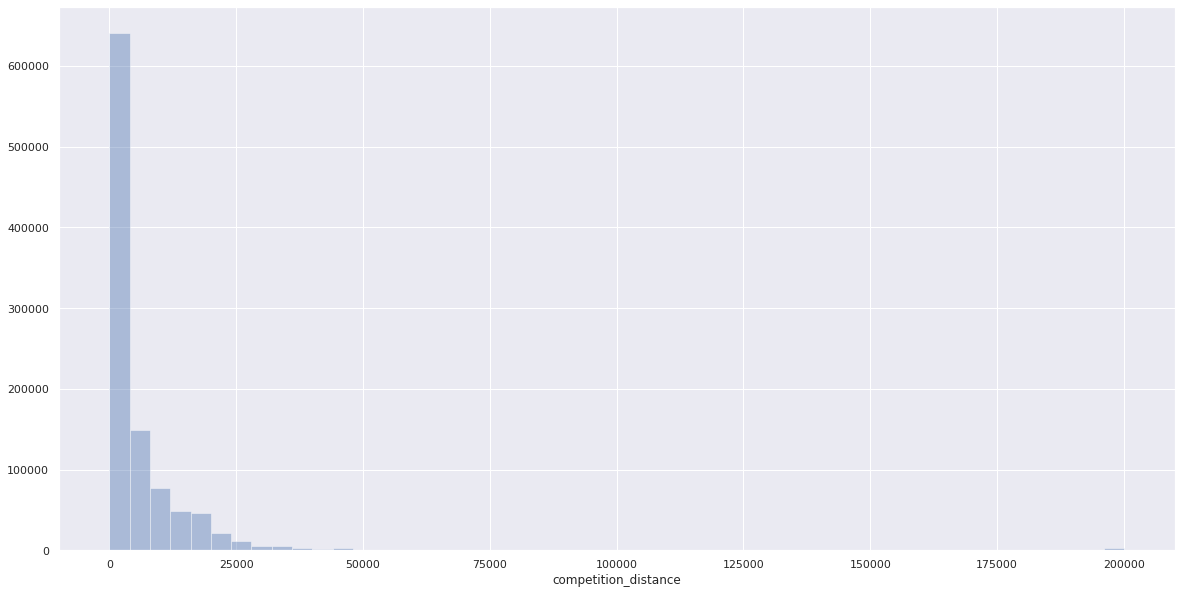

In [ ]:
sns.distplot(df1['competition_distance'], kde= False)

### 1.7.2 Categorical Attributes

In [ ]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

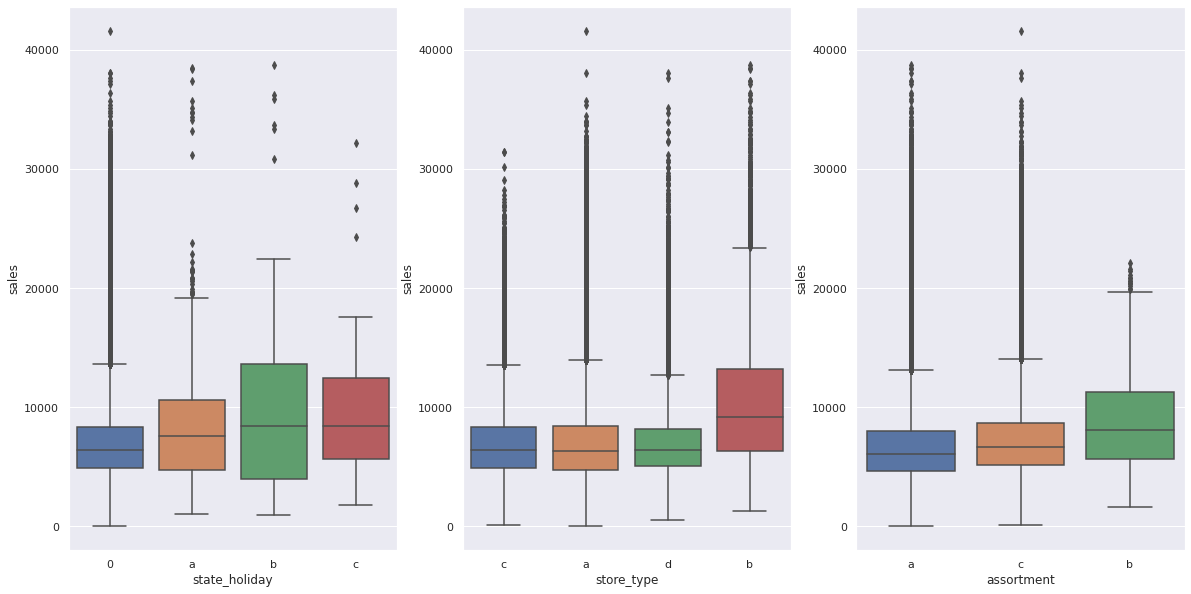

In [ ]:
aux = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0) ]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y= 'sales', data= aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y= 'sales', data= aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y= 'sales', data= aux)




# 2.0 Feature Engineering

## 2.1 Hypothesis Maps

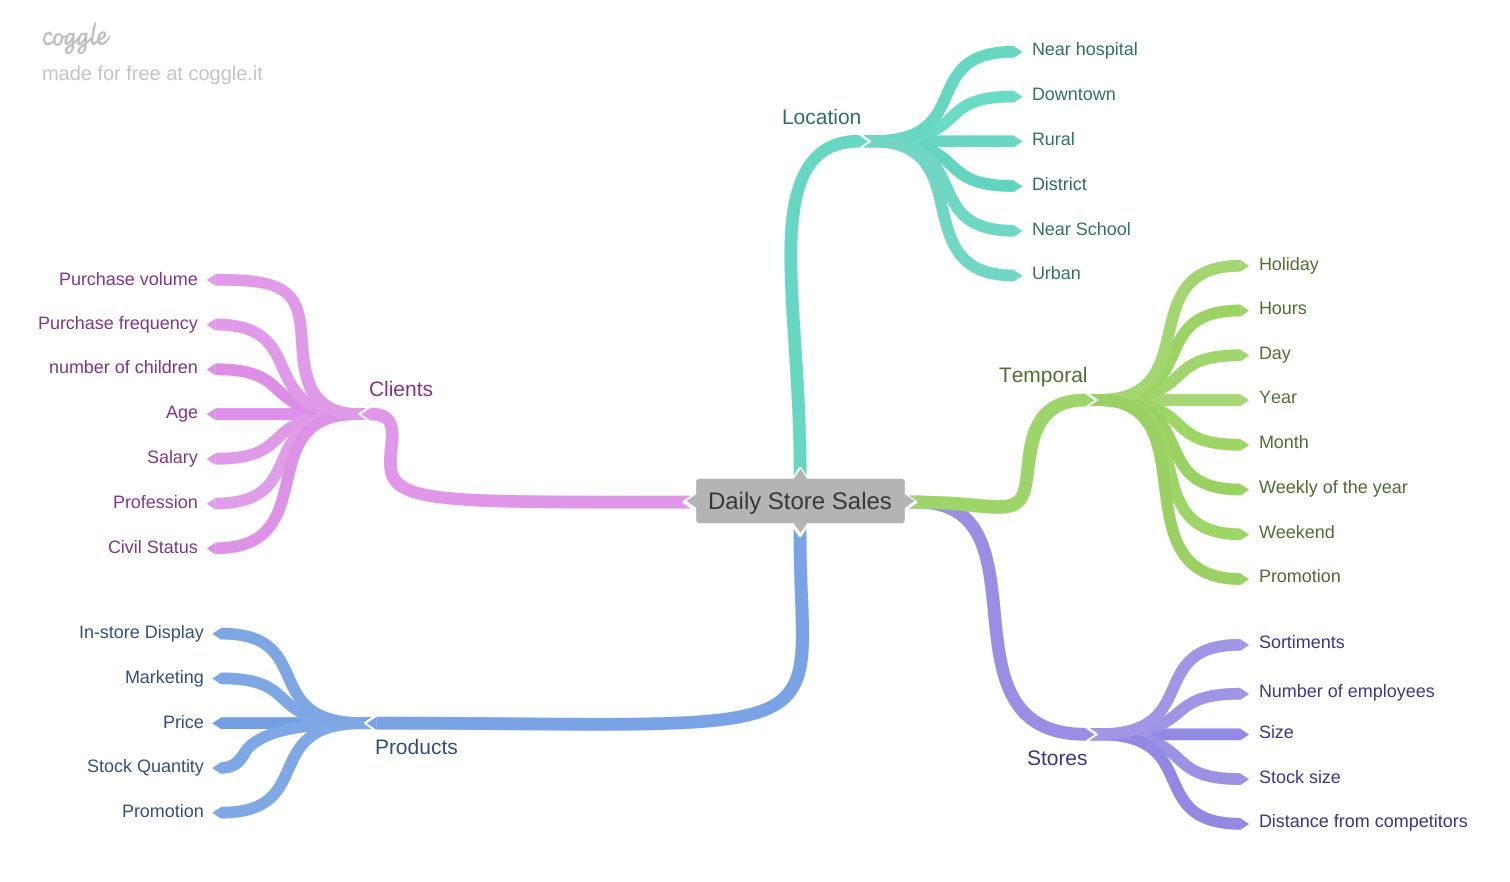

In [ ]:
Image('../img/MindMapHypothesis.png')

## 2.2 Creation of Hypotheses

### 2.2.1 Store's Hypothesis 

**1 -** Stores with more employees should sell more.

**2 -** Stores with a larger inventory should sell more.

**3 -** Larger stores should sell more.

**4 -** Stores with closer competitors should sell less.

**5 -** Stores with a larger assortment should sell more.

**6 -** Stores with longer competitors should sell more.

### 2.2.2 Product's Hypothesis 

**1 -** Stores that invest more in Marketing should sell more.

**2 -** Stores that exhibit more product in store windows should sell more.

**3 -** Stores that have lower prices should sell more.

**4 -** Stores with more aggressive promotions (bigger discounts), should sell more.

**5 -** Stores that have prices less for longer products should sell more.

**6 -** Stores with more promotion days should sell more.

**7 -** Stores with more consecutive promotions should sell more.

### 2.2.3 Time's Hypothesis 

**1 -** Stores opened during the holiday should sell more.

**2 -** Stores should sell more over the years

**3 -** Stores should sell more in the second half of the year.

**4 -** Stores should sell more after the 10th of each month.

**5 -** Stores should sell less on weekends.

**6 -** Stores should sell less during school holidays.

## 2.3 Final Hypothesis 

- Store

**1 -** Stores with closer competitors should sell less.

**2 -** Stores with a larger assortment should sell more.

**3 -** Stores with longer competitors should sell more.

- Products

**4 -** Stores with active promotions for longer should sell more.

**5 -** Stores with more promotion days should sell more.

**6 -** Stores with more consecutive promotions should sell more.

- Time

**7 -** Stores open during the holiday should sell more.

**8 -** Stores should sell more over the years.

**9 -** Stores should sell more in the second half of the year.

**10 -** Stores should sell more after the 10th of each month.

**11 -** Stores should sell less on weekends.

**12 -** Stores should sell less during school holidays.


## 2.4 Feature Engineering

In [ ]:
df2 = df1.copy()

In [ ]:
import datetime

#year 
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')


#competition of since
df2['competition_since']= df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')- datetime.timedelta( days=7 ))
df2['promo_since_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] =df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x =='c' else 'regular_day')



In [ ]:
df2.head().T

,0,1,2,3,4
store,1,1,1,1,1
day_of_week,5,4,3,2,1
date,2015-07-31 00:00:00,2015-07-30 00:00:00,2015-07-29 00:00:00,2015-07-28 00:00:00,2015-07-27 00:00:00
sales,5263,5020,4782,5011,6102
customers,555,546,523,560,612
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,c,c,c,c


# 3.0 Variable Filtering

In [ ]:
df3 = df2.copy()

In [ ]:
df3.head().T

,0,1,2,3,4
store,1,1,1,1,1
day_of_week,5,4,3,2,1
date,2015-07-31 00:00:00,2015-07-30 00:00:00,2015-07-29 00:00:00,2015-07-28 00:00:00,2015-07-27 00:00:00
sales,5263,5020,4782,5011,6102
customers,555,546,523,560,612
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,c,c,c,c


## 3.1 Rows Filtering

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selection Columns

In [ ]:
col_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(col_drop, axis = 1)

In [ ]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_since_week'],
      dtype='object')

# 4.0 Exploratory Analysis

In [ ]:
df4 = df3.copy()

## 4.1 Analysis Univariate

### 4.1.1 Response Variable

### 4.1.2 Numerical Variable

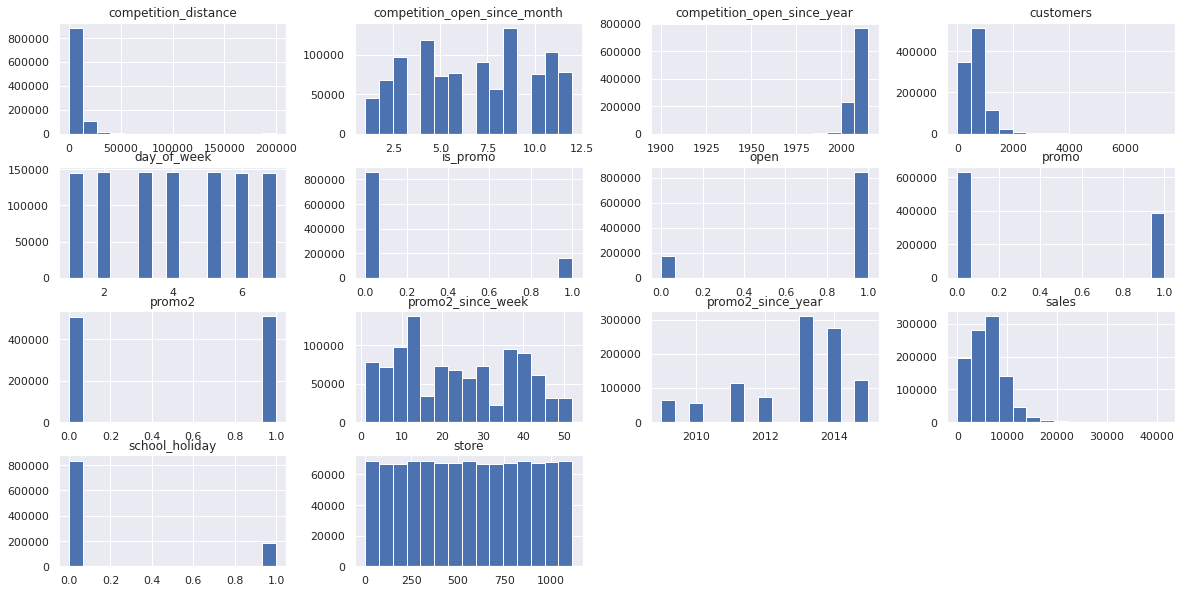

In [ ]:
num_attributes.hist(bins=15);

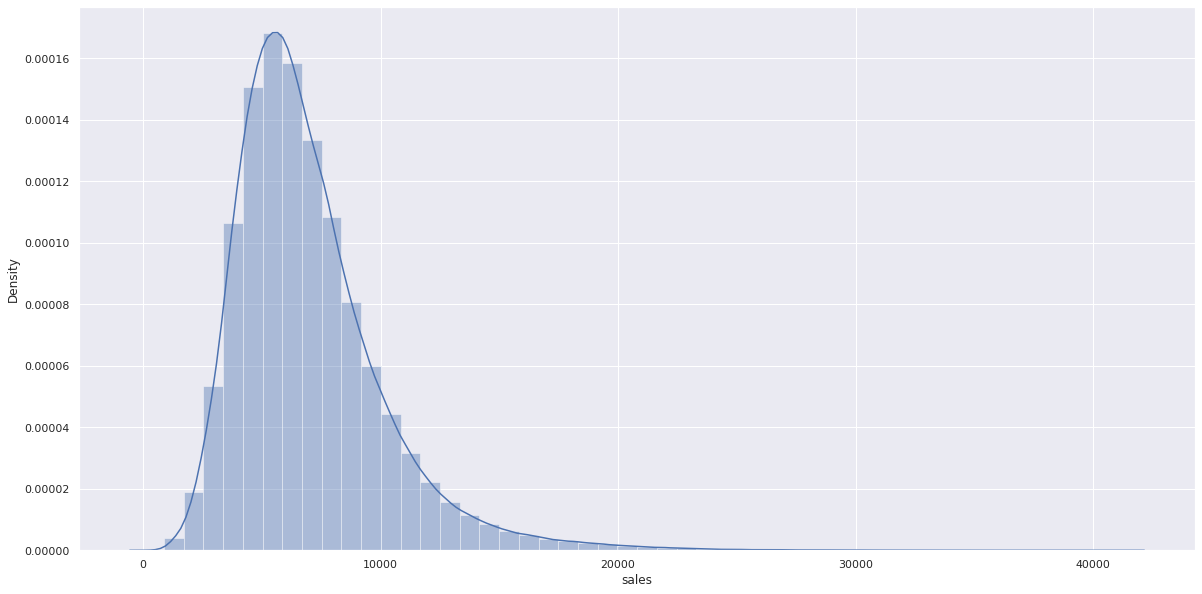

In [ ]:
sns.distplot(df4['sales'], kde=True)

### 4.1.3 Categorical Variable

In [ ]:
df4['state_holiday'].drop_duplicates()

0           regular_day
1243     public holiday
76852    Easter holiday
76953         Christmas
Name: state_holiday, dtype: object

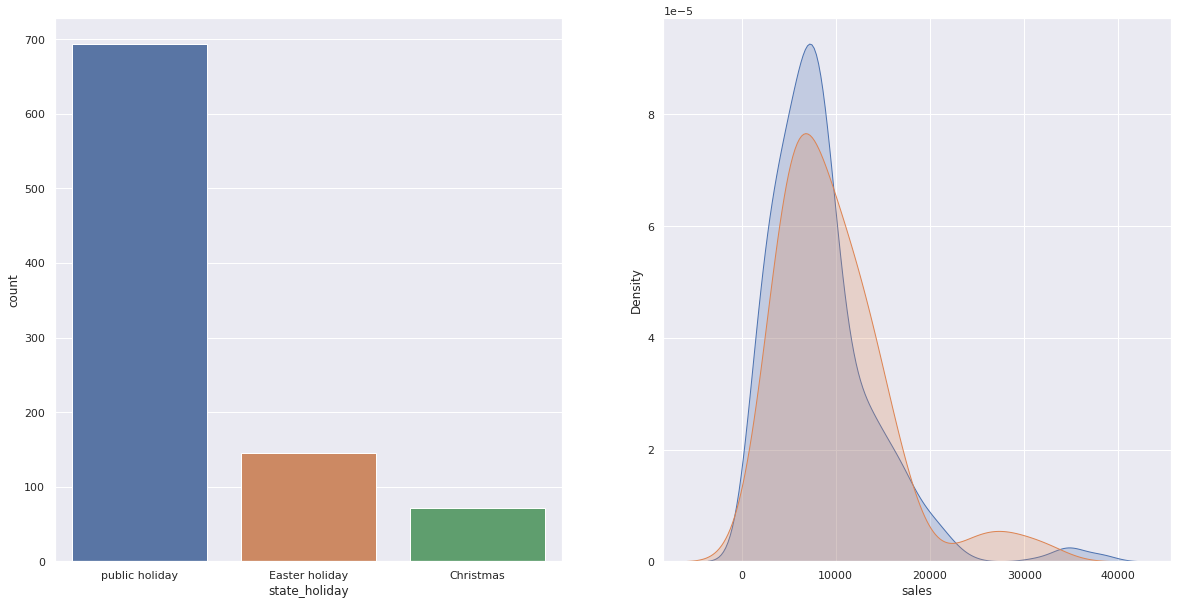

In [ ]:
#state_holiday
a = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
sns.countplot(a['state_holiday']);

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter holiday']['sales'],label = 'easter_holiday',shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'],label = 'Christmas',shade = True);

## 4.2 Analysis Bivariate

### 4.2.1 - Hypothesis

#### H1-  Stores with closer competitors should sell less.
**False** Stores with closer competitors sell MORE

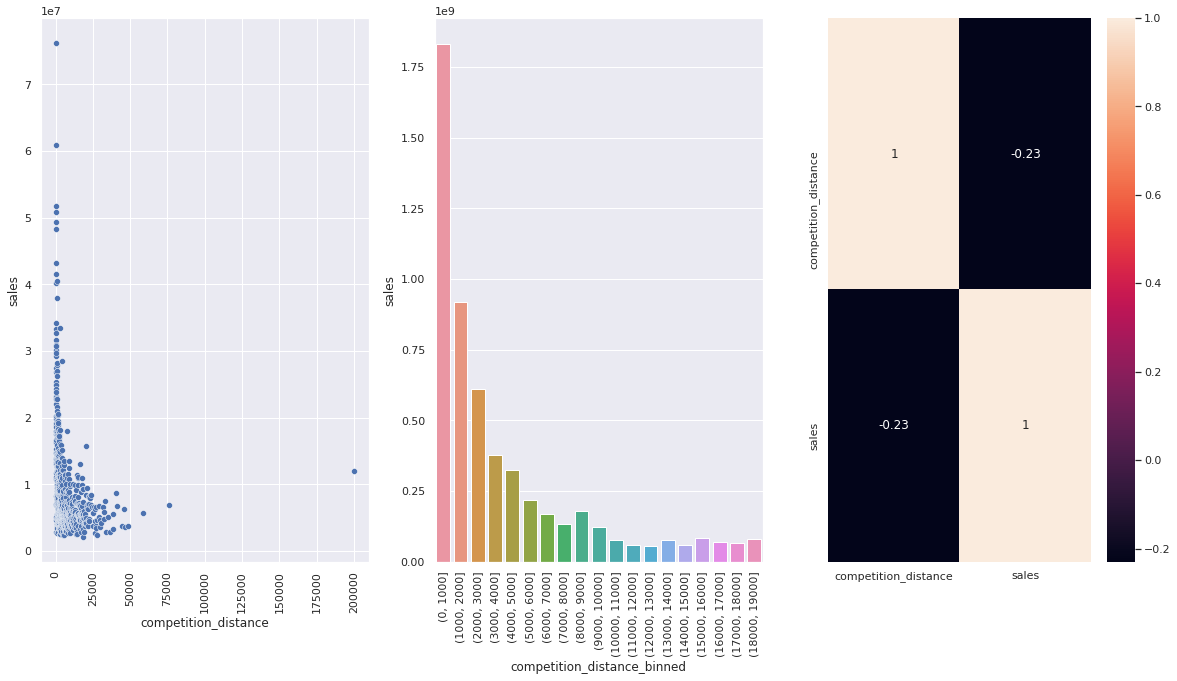

In [ ]:
aux01= df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

#Plotting charts
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data= aux01);
plt.xticks(rotation=90);

bins = list(np.arange(0,20000,1000))
aux01['competition_distance_binned'] = pd.cut(aux01['competition_distance'], bins= bins)
aux02= aux01[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2) 
sns.barplot(x='competition_distance_binned', y='sales', data= aux02);
plt.xticks(rotation=90);

plt.subplot(1,3,3)

corr = sns.heatmap(aux01.corr(method='pearson'),annot=True)
#bottom, top = corr.get_ylim()
#corr.set_ylim(bottom+0.5, top-0.5)

#### H2- Stores with a larger assortment should sell more.
**False** Stores with a  larger assortment sell LESS

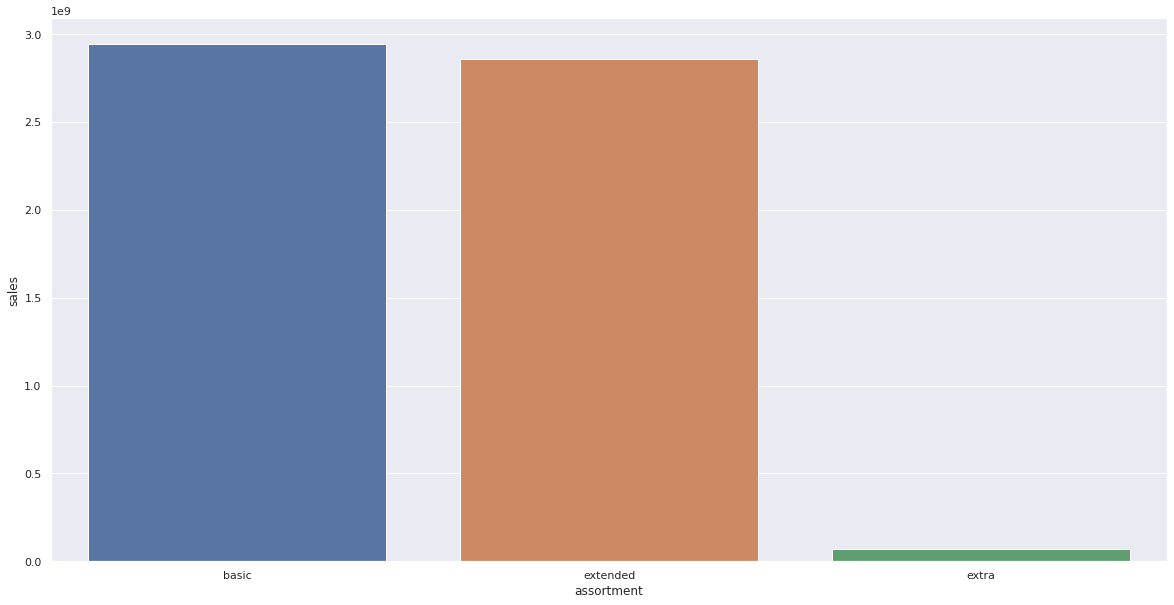

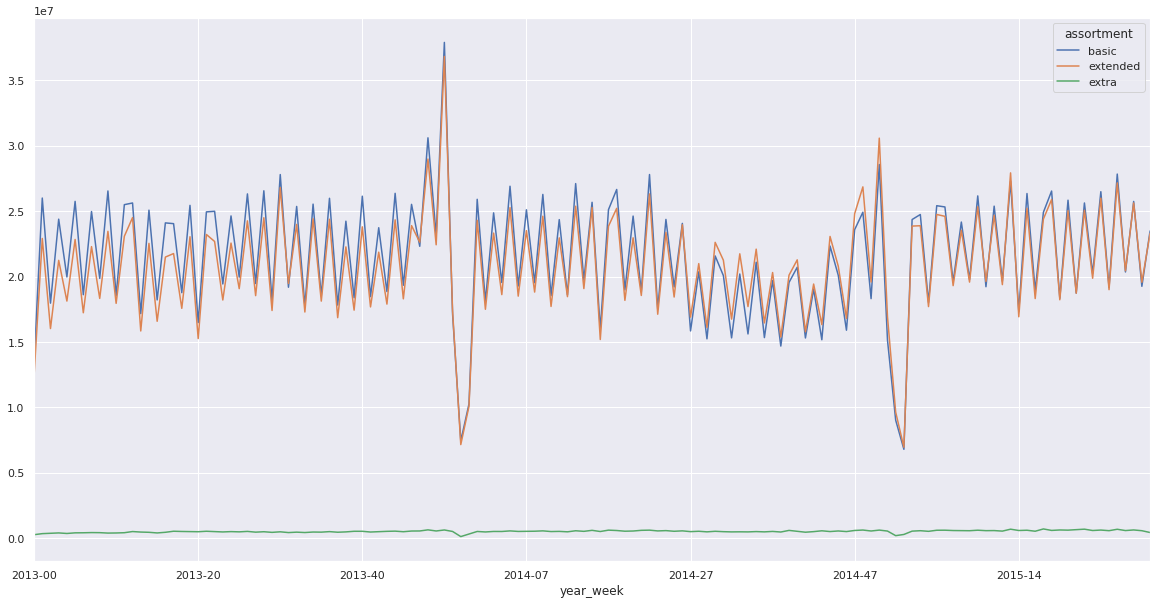

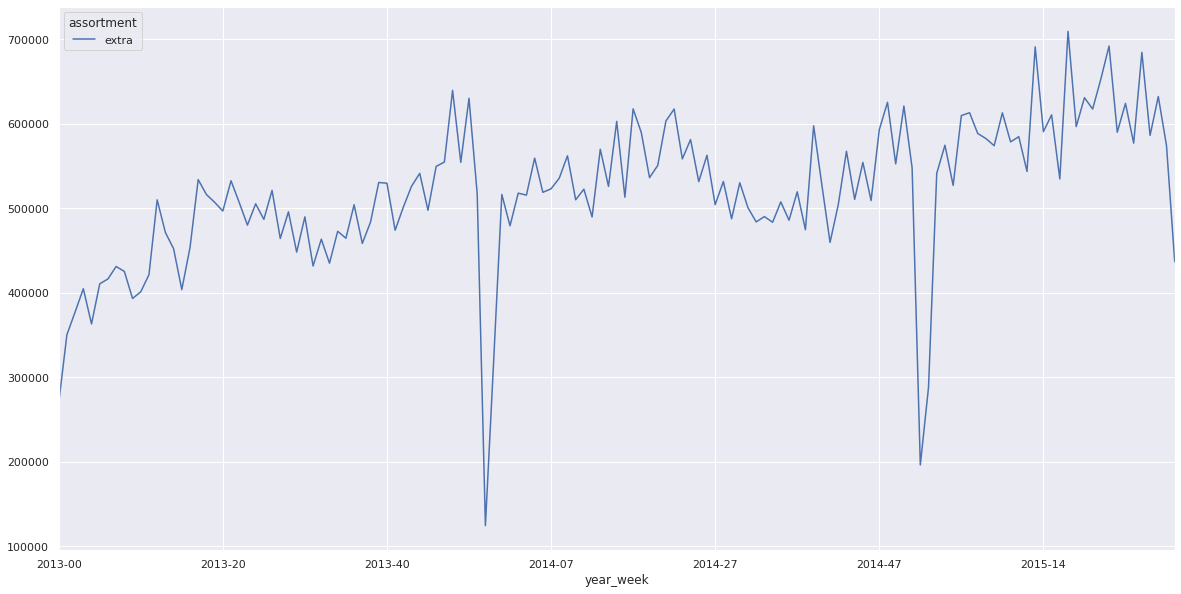

In [ ]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()

sns.barplot(x='assortment', y='sales', data= aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

aux2.pivot(index='year_week', columns='assortment', values='sales').plot()


aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

#### H3- Stores with longer competitors should sell more.
**False** Stores with longer competitors sell LESS

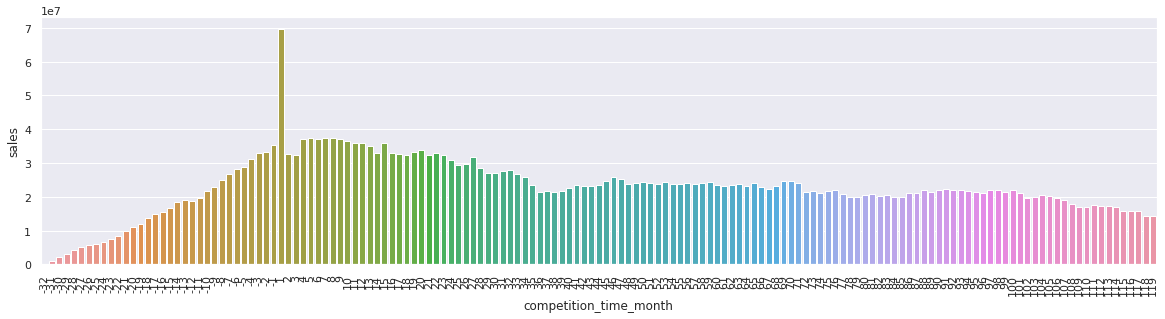

In [ ]:
aux01= df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux02 = aux01[(aux01['competition_time_month'] < 120) & (aux01['competition_time_month'] != 0)]


plt.subplot(2,1,1)
sns.barplot(x='competition_time_month', y='sales', data= aux02);
plt.xticks(rotation=90);

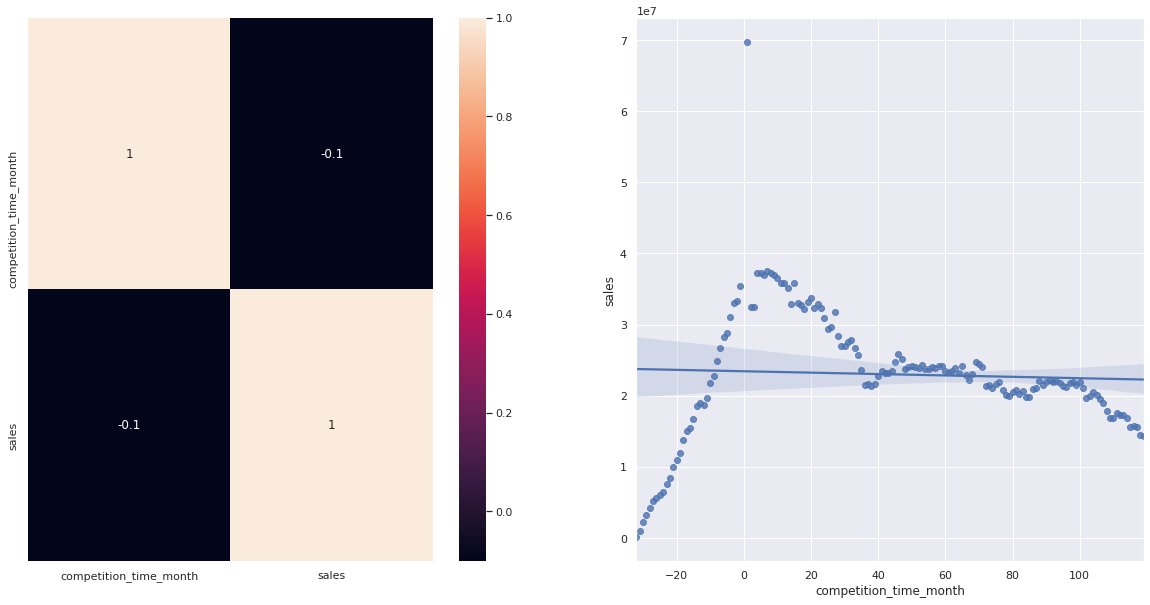

In [ ]:
plt.subplot(1,2,1)
corr = sns.heatmap(aux01.corr(method='pearson'),annot=True);

plt.subplot(1,2,2)
sns.regplot(x='competition_time_month', y='sales', data= aux02);

#### H4- Stores with active promotions for longer should sell more.
**False** Stores with active promotions sell less after a certain duration.

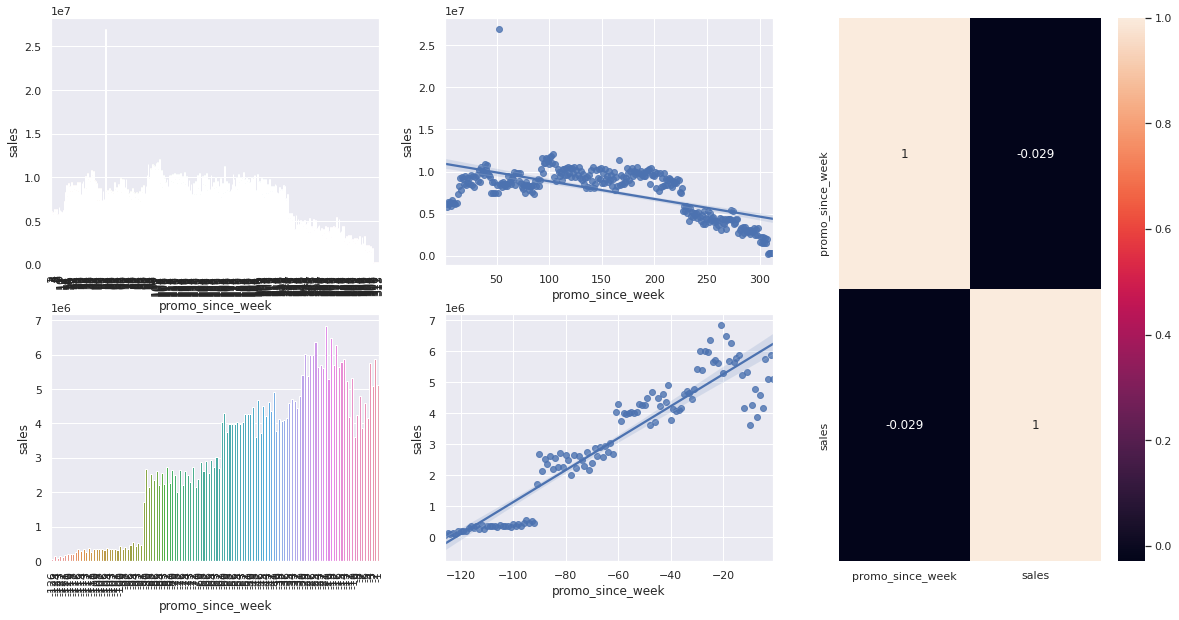

In [ ]:
aux1= df4[['promo_since_week', 'sales']].groupby('promo_since_week').sum().reset_index()


grid =gridspec.GridSpec(2,3)


plt.subplot(grid[ 0, 0])
aux2= aux1[aux1['promo_since_week'] > 0 ] #promo extendido
sns.barplot(x='promo_since_week', y= 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(grid[ 0, 1])
sns.regplot(x='promo_since_week', y= 'sales', data = aux2);


plt.subplot(grid[ 1, 0])
aux3= aux1[aux1['promo_since_week'] < 0 ] # promo regular
sns.barplot(x='promo_since_week', y= 'sales', data = aux3);
plt.xticks(rotation=90);

plt.subplot(grid[ 1, 1])
sns.regplot(x='promo_since_week', y= 'sales', data = aux3);

plt.subplot (grid[ :, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### <s> H5-Stores with more promotion days should sell more. </s>


#### H6- Stores with more consecutive promotions should sell more.
**False** Stores with more consecutive promotions sell LESS

In [ ]:
df4[['promo', 'promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


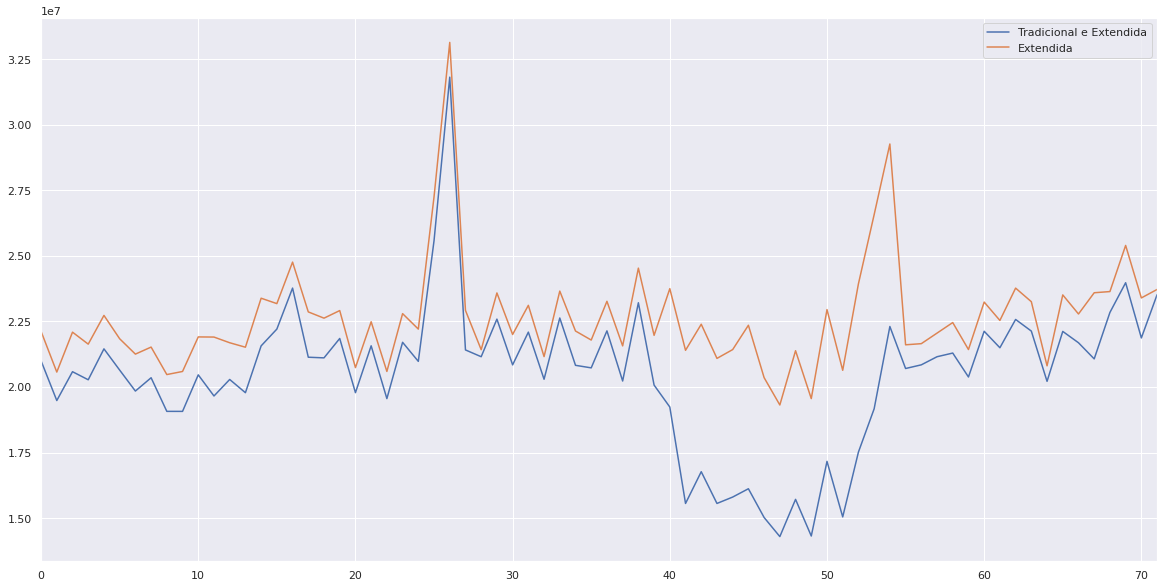

In [ ]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida','Extendida'])

#### H7- Stores open during the holiday should sell more.
**False** Stores open during the holiday sell LESS

In [ ]:
df4.head(3)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_since_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,1,4,2015-07-30,5020,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,30,31,2015-30,2008-09-01,84,2015-07-27,0
2,1,3,2015-07-29,4782,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,29,31,2015-30,2008-09-01,84,2015-07-27,0


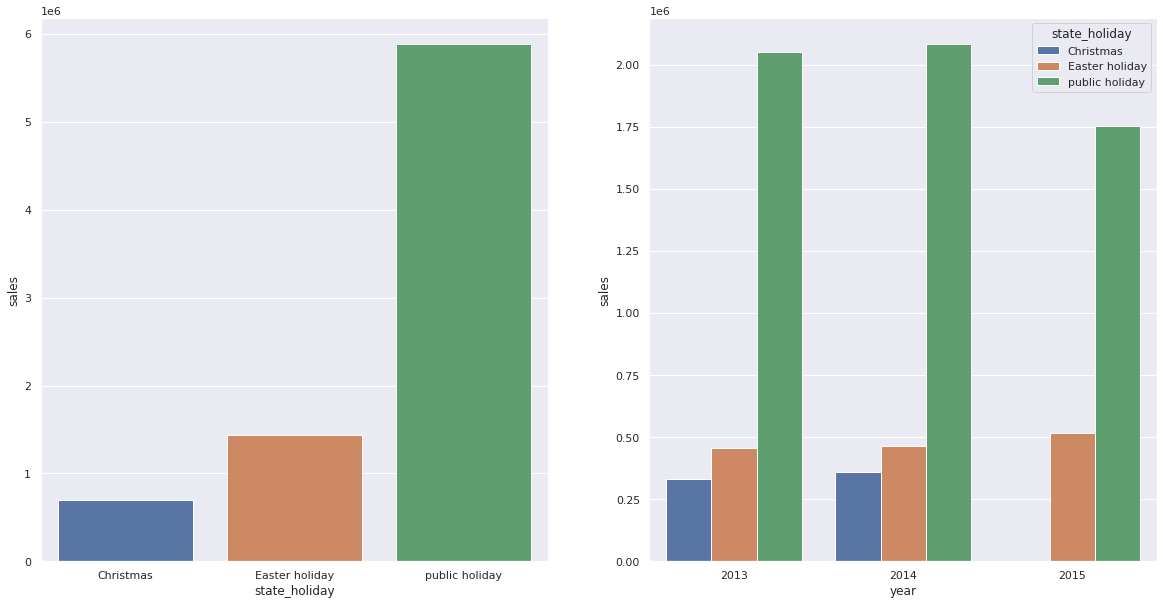

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2= aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue= 'state_holiday', data=aux2);

#### H8- Stores should sell more over the years.
**False** Stores sell LESS over the years

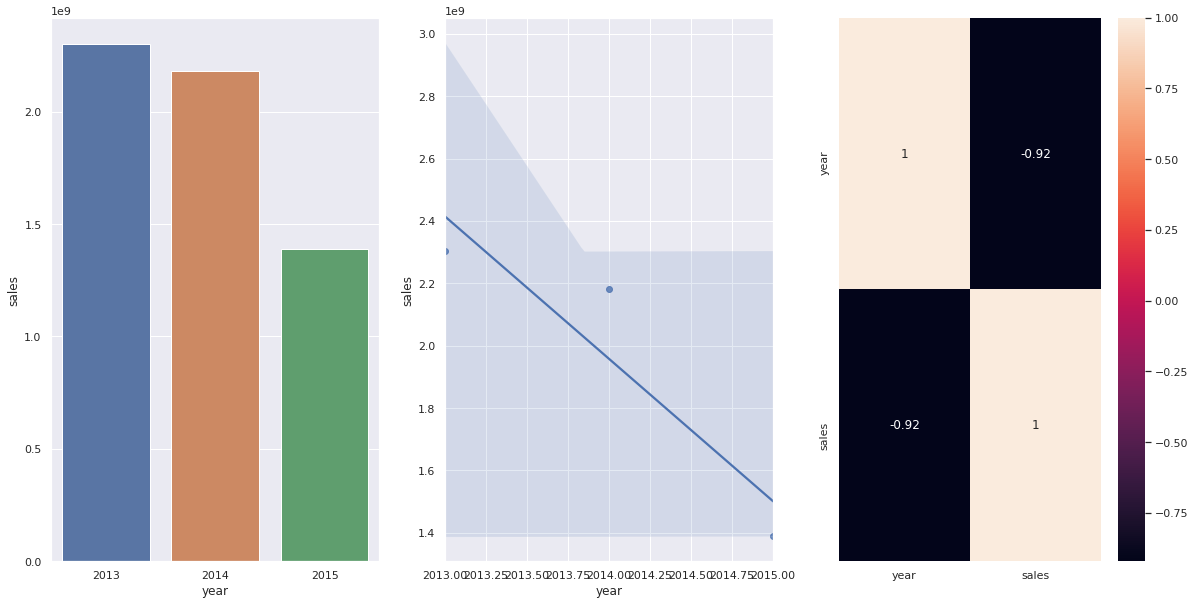

In [ ]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)



#### H9- Stores should sell more in the second half of the year.
**False** Stores sell LESS in the second half of the year

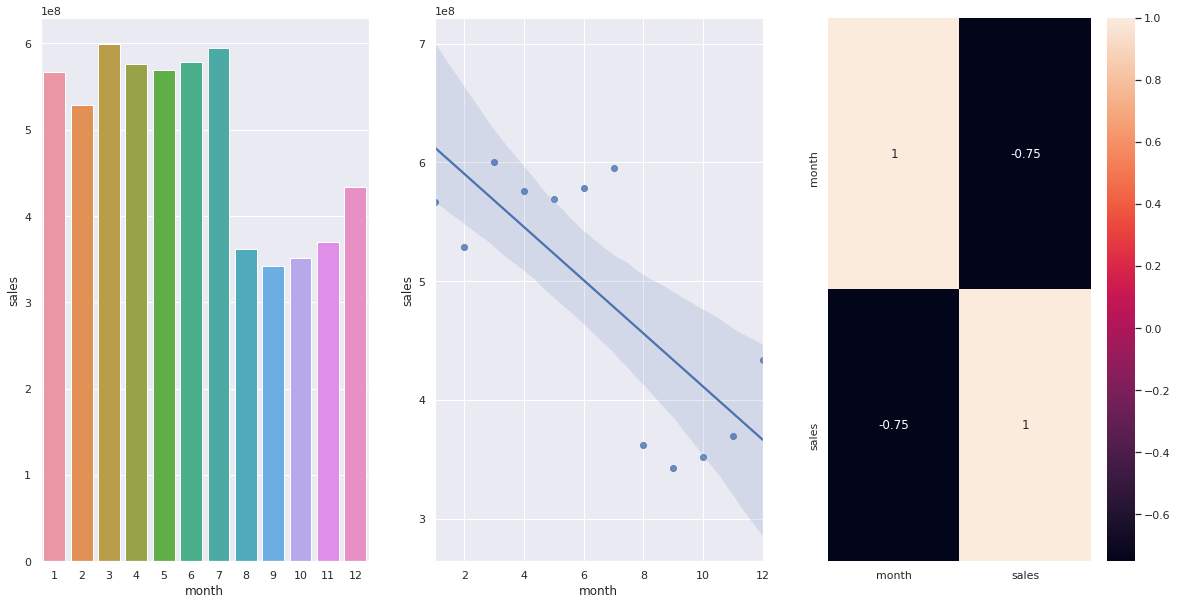

In [ ]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

#### H10-Stores should sell more after the 10th of each month.

**True** Stores sell more after the 10th of each month.

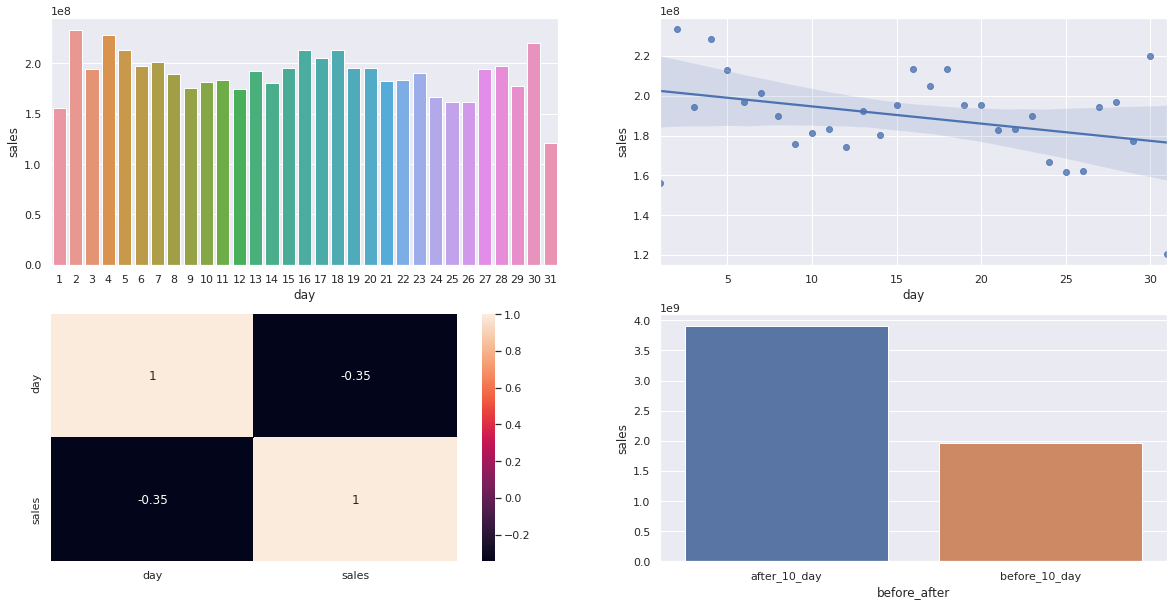

In [ ]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data= aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data= aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data= aux2);

#### H11- Stores should sell less on weekends.
**True** Stores sell less on weekends.

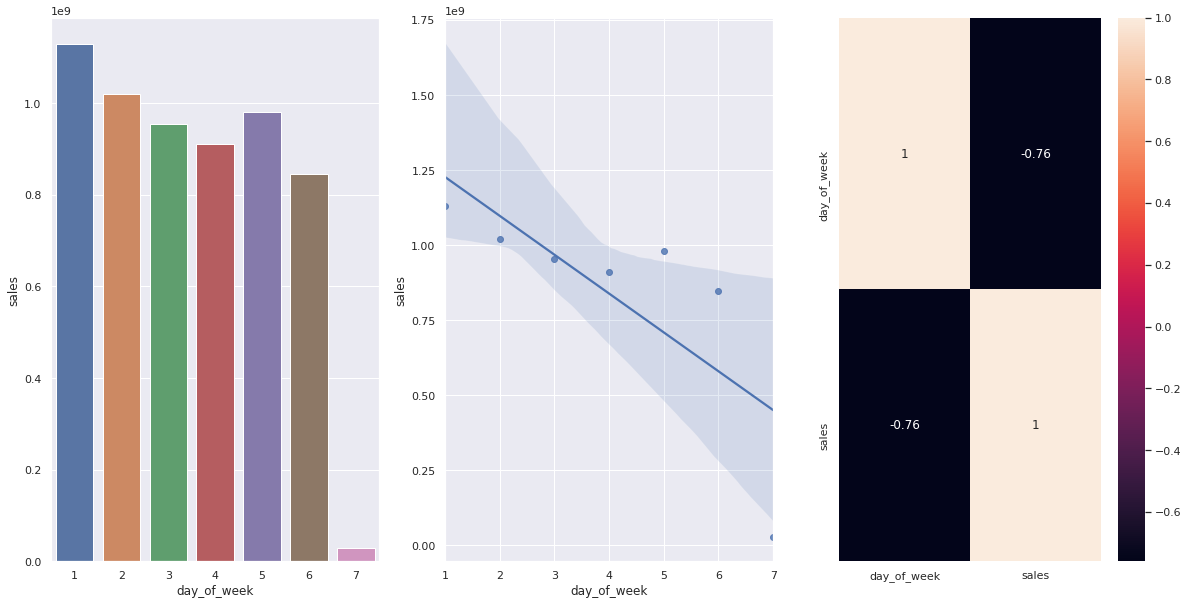

In [ ]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

#### H12- Stores should sell less during school holidays.
**TRUE** Stores sell less during school holidays except July and August

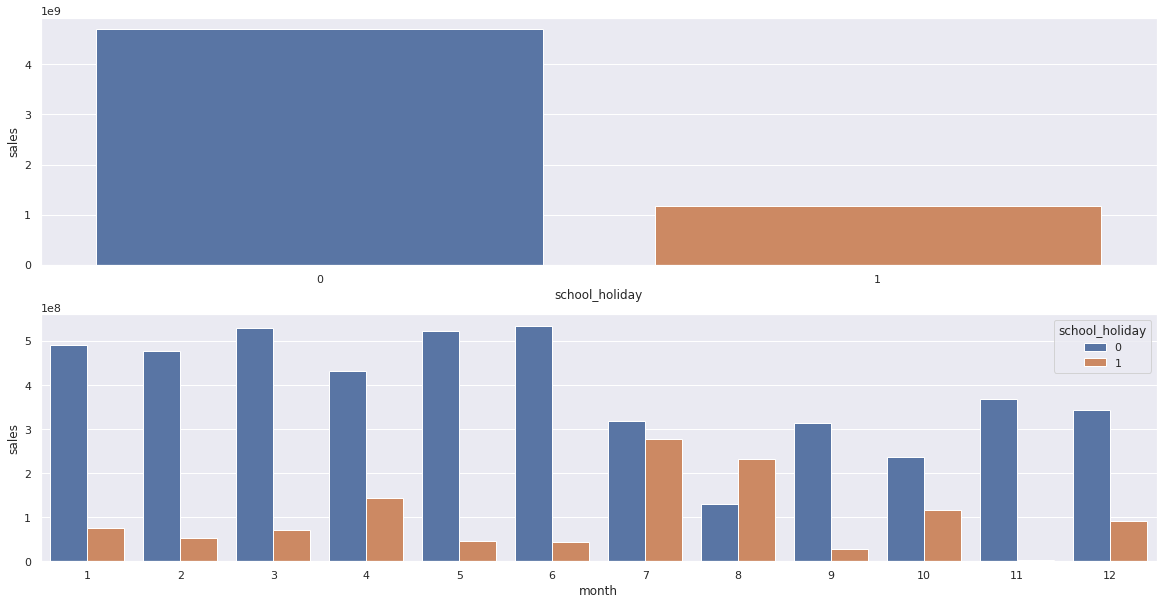

In [ ]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data= aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales',hue='school_holiday', data= aux2);


### 4.2.2 - Resume of Hypotheses

In [ ]:
tab =[['Hypotheses', 'Conclusion','Relevance'],
       ['H1','False', 'Low'],
       ['H2','False', 'Medium'],
       ['H3','False', 'Medium'],
       ['H4','False', 'Low'],
       ['H5','---', '---'],
       ['H6','False', 'Low'],
       ['H7','False', 'Medium'],
       ['H8','False', 'High'], 
       ['H9','False', 'High'], 
       ['H10','True', 'High'],
       ['H11','True', 'High'],
       ['H12','True', 'Low'],
] 

print(tabulate(tab, headers='firstrow'))

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            ---           ---
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3 Analysis Multivariate


### 4.3.1 - Numerical Attributes

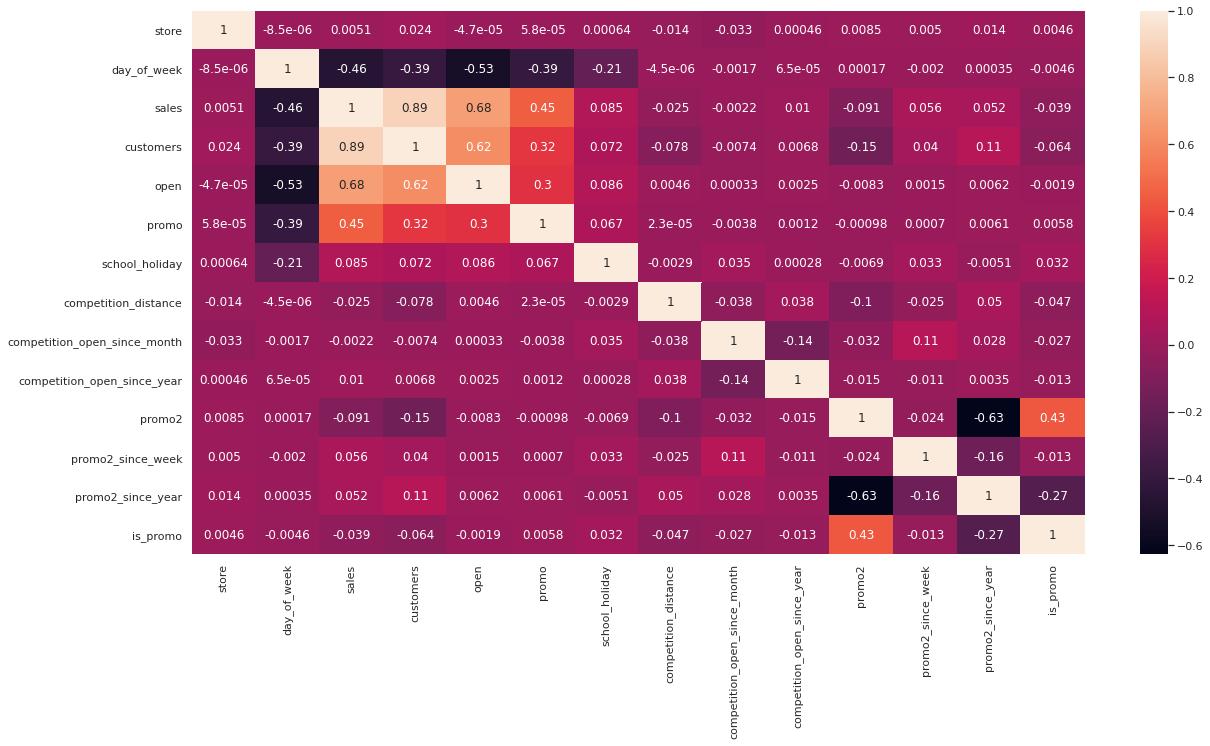

In [ ]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 - Categorical Attributes

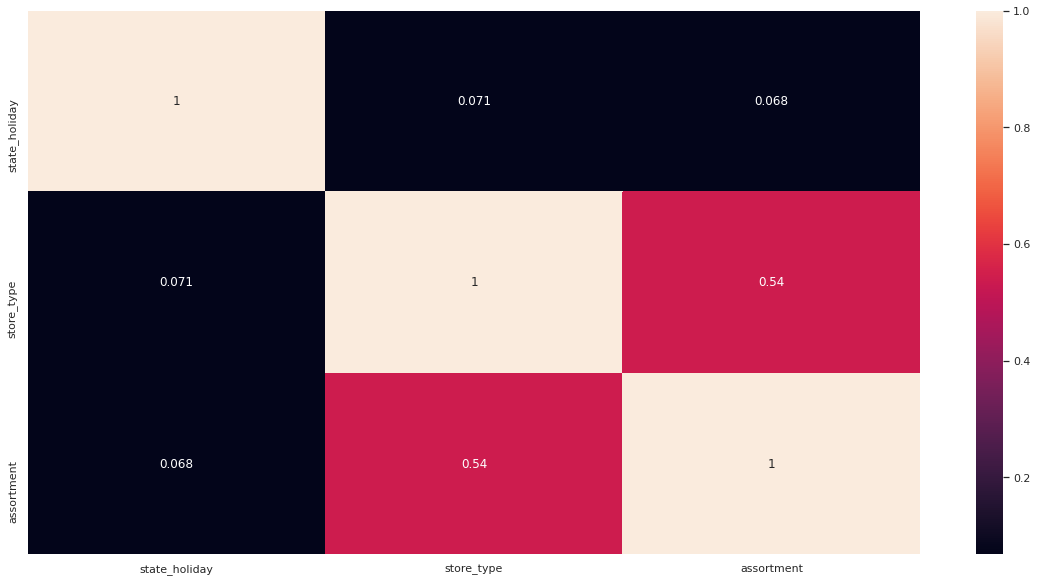

In [ ]:
# only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final Dataset

data = pd.DataFrame({'state_holiday':[a1,a2,a3],
                     'store_type':[a4,a5,a6],
                     'assortment':[a7,a8,a9]})

data = data.set_index(data.columns)
sns.heatmap(data,annot=True)

# 5.0 Data Preparation

In [ ]:
df5 = df4.copy()

## 5.1 Normalization

Check variables that have a Guaussian distribution

## 5.2 Rescaling

In [ ]:
a = df5.select_dtypes(include=['float64','int64'])

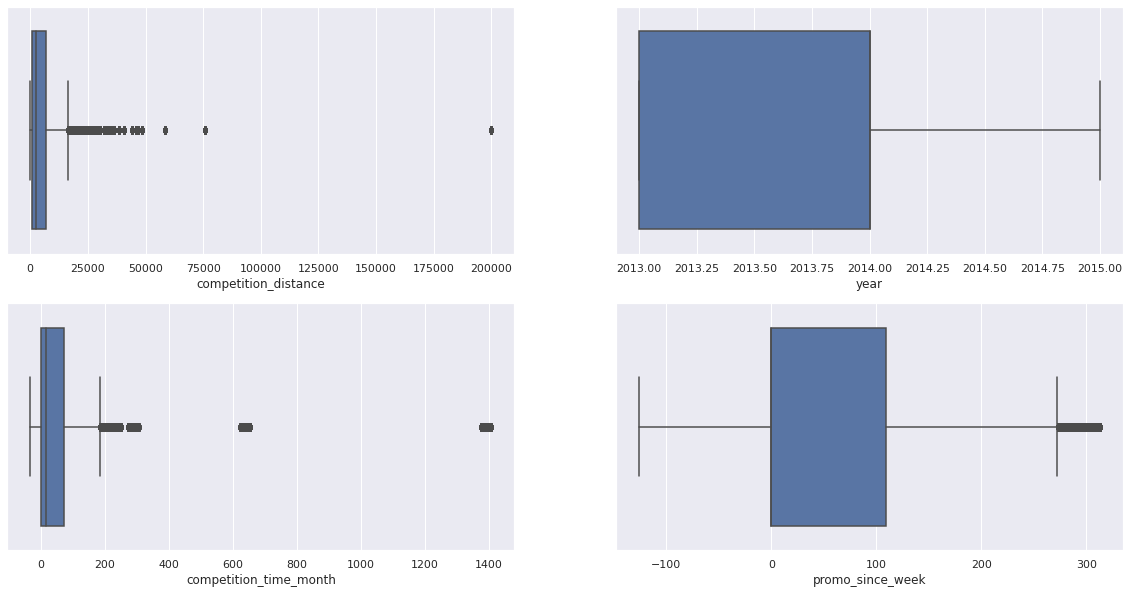

In [ ]:
plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance']);

plt.subplot(2,2,2)
sns.boxplot(df5['year']);

plt.subplot(2,2,3)
sns.boxplot(df5['competition_time_month']);

plt.subplot(2,2,4)
sns.boxplot(df5['promo_since_week']);

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance (Robust)
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( '/content/drive/MyDrive/Meusdocumentos/Rossman/parameter/competition_distance_scaler.pkl', 'wb'))

#competition_time_month (Robust)
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( '/content/drive/MyDrive/Meusdocumentos/Rossman/parameter/competition_time_month_scaler.pkl', 'wb'))

#year (Rescale)
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open( '/content/drive/MyDrive/Meusdocumentos/Rossman/parameter/year_scaler.pkl', 'wb'))

#promo_since_week (Rescale)
df5['promo_since_week'] = mms.fit_transform(df5[['promo_since_week']].values)
pickle.dump( mms, open( '/content/drive/MyDrive/Meusdocumentos/Rossman/parameter/promo_since_week_scaler.pkl', 'wb'))


## 5.3 Transformation

### 5.3.1 Encoding

In [ ]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open('/content/drive/MyDrive/Meusdocumentos/Rossman/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic':1,'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [ ]:
df5['sales']= np.log1p(df5['sales'])

### 5.3.2 Nature Transformation

In [ ]:
#month
df5['month_sin']= df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos']= df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

#day
df5['day_sin']= df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos']= df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

#week_of_year
df5['week_of_year_sin']= df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos']= df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

#day_of_week
df5['day_of_week_sin']= df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos']= df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# 6.0 Feature Selection

## 6.1 Split Dataframe Into Training and Test Dataset

In [ ]:
cols_drop = ['day', 'month', 'week_of_year', 'day_of_week','year_week','competition_since','promo_since']
df5 = df5.drop(cols_drop, axis=1)

In [ ]:
df5[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [ ]:
#Training dataset
X_train = df5[df5['date'] < '2015-06-19']
y_train = X_train['sales']  

#Test dataset
X_test = df5[df5['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min date: {}'.format(X_train['date'].min()))
print('Training Max date: {}'.format(X_train['date'].max()))

print('\nTest Min date: {}'.format(X_test['date'].min()))
print('Test Max date: {}'.format(X_test['date'].max()))

Training Min date: 2013-01-01 00:00:00
Training Max date: 2015-06-18 00:00:00

Test Min date: 2015-06-19 00:00:00
Test Max date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [ ]:
#Training and test dataset for Boruta

#X_train_n = X_train.drop(['date','sales'],axis=1).values
#y_train_n = y_train.values.ravel()

#Define RandomForest Regressor

#rf = RandomForestRegressor(n_jobs=-1)

#Define Boruta

#boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train_n,y_train_n)

### 6.2.1 Best Features from Boruta

In [ ]:
#cols_selected= boruta.support_.tolist()

#Best features 

#X_train_fs = X_train.drop(['sales','date'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

#Not selected Boruta

#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

#Check selected columns
#cols_selected_boruta 
#cols_not_selected_boruta 


### 6.3. Manual Feature Selection

In [ ]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2','promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_since_week',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'day_of_week_sin', 
                        'day_of_week_cos']


# columns to add
feat_to_add = ['date','sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )


# 7.0 Machine Learning

In [ ]:
x_train =  X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full]

## 7.1 Average Model


In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction

aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance

baseline_result = ml_error('Average Model',np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.413001,1835.135542


## 7.2 Linear Regression Model

In [ ]:
#model
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.313299,0.292392,2674.576594


### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation(x_training,5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.69+/-293.36,0.3+/-0.02,2950.49+/-464.71


## 7.3 Linear Regression Regularized Model - Lasso

In [ ]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


### 7.3.1 Linear Regression Model Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation(x_training,5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


## 7.4 Random Forest Regressor

In [ ]:
#model
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(x_train,y_train)
#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,708.26789,0.105126,1044.319294


### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training,5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,839.07+/-218.69,0.12+/-0.02,1257.83+/-320.83


## 7.5 XGBoost Regressor

In [ ]:
#model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9).fit(x_train,y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,847.925095,0.122826,1250.039502


### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1048.66+/-183.98,0.14+/-0.02,1511.8+/-257.32


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [ ]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,708.267890,0.105126,1044.319294
0,XGBoost Regressor,847.925095,0.122826,1250.039502
0,Average Model,1354.800353,0.413001,1835.135542
0,Linear Regression,1868.313299,0.292392,2674.576594
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451735


### 7.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.69+/-293.36,0.3+/-0.02,2950.49+/-464.71
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
0,Random Forest Regressor,839.07+/-218.69,0.12+/-0.02,1257.83+/-320.83
0,XGBoost Regressor,1048.66+/-183.98,0.14+/-0.02,1511.8+/-257.32


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [ ]:
# param = {
#          'n_estimators':[1500,1700,2500,3000,3500],
#          'eta':[0.01,0.03],
#          'max_depth':[3,5,9],
#          'subsample':[0.1,0.5,0.7],
#          'colsample_bytee':[0.3,0.7,0.9],
#          'min_child_weight':[3,8,15]
#         }
# MAX_EVAL = 5

In [ ]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     #choose values for parameters randomly
#     hp = {k: random.sample(v,1)[0] for k,v in param.items()}
#     print(hp)
    
#     #model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   colsample_bytee=hp['colsample_bytee'],
#                                   min_child_weight = hp['min_child_weight'])


#     #performance
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#     final_result = pd.concat([final_result,result])

# final_result

## 8.2 Final Model

In [ ]:
 param_tuned = {
         'n_estimators':3000,
         'eta':0.03,
         'max_depth':5,
         'subsample':0.7,
         'colsample_bytree':0.7,
         'min_child_weight':3
        }

In [ ]:
# #model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=param_tuned['n_estimators'],
                              eta=param_tuned['eta'],
                              max_depth=param_tuned['max_depth'],
                              subsample=param_tuned['subsample'],
                              colsample_bytree=param_tuned['colsample_bytree'],
                              min_child_weight =param_tuned['min_child_weight']).fit(x_train,y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
 
xgb_result_tuned = ml_error('XGBoost Regressor Tuned',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor Tuned,675.419295,0.099971,967.715559


# 9.0 Error Interpretation

In [ ]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [ ]:
#sum of predictions
df9_aux = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store','predictions','sales']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','predictions','sales']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#Merge
df9_aux3 = pd.merge(df9_aux1,df9_aux2,how='inner',on='store')
df9_aux4 = pd.merge(df9_aux,df9_aux3,how='inner',on='store')

#Scenarios

df9_aux4['worst_scenario'] = df9_aux4['predictions'] - df9_aux4['MAE']
df9_aux4['best_scenario'] = df9_aux4['predictions'] + df9_aux4['MAE']

#order columns

df9_aux4= df9_aux4[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]


In [ ]:
df9_aux4.sort_values("MAPE", ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105474.804688,102203.578536,108746.030839,3271.226151,0.560804
908,909,241753.250000,234186.343347,249320.156653,7566.906653,0.519045
875,876,200335.375000,196367.398968,204303.351032,3967.976032,0.300858
721,722,352965.312500,350974.250079,354956.374921,1991.062421,0.266647
273,274,191570.484375,190127.837686,193013.131064,1442.646689,0.250191


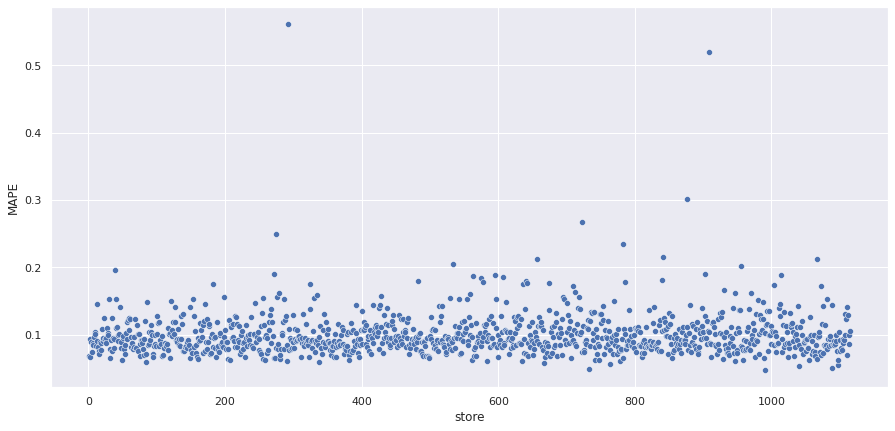

In [ ]:
plt.figure(figsize = (15,7))
sns.scatterplot(x = 'store',y = 'MAPE', data = df9_aux4);

## 9.2 Total Performance

In [ ]:
df9_aux5 = df9_aux4[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index': 'Scenarios',0:'Values'})
df9_aux5['Values'] = df9_aux5['Values'].map('R${:,.2f}'.format)
df9_aux5



,Scenarios,Values
0,predictions,"R$287,872,185.41"
1,worst_scenario,"R$287,115,126.03"
2,best_scenario,"R$288,629,244.80"


## 9.3 Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] /df9['sales']


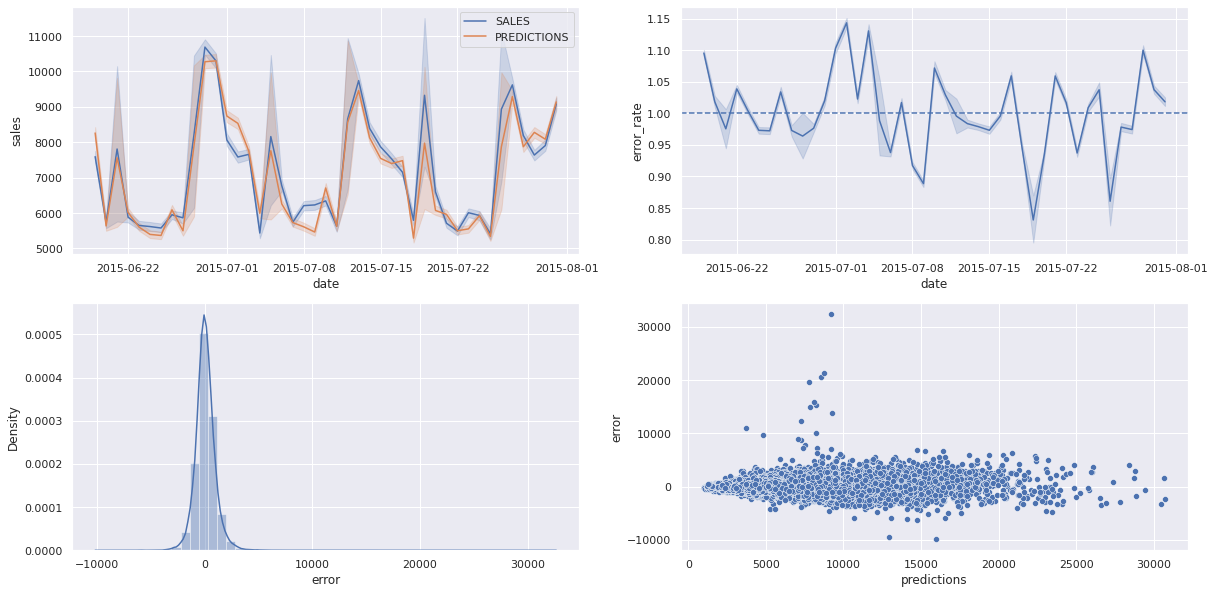

In [ ]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9,label='SALES');
sns.lineplot(x='date',y='predictions',data=df9,label='PREDICTIONS');

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9);
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error']);

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'],df9['error']);


# 10.0 Deploy model to production

In [ ]:
#Save Trained Model
pickle.dump(model_xgb_tuned,open('/content/drive/MyDrive/Meusdocumentos/Rossman/parameter/model_rossman.pkl','wb'))

## 10.1 Rossmann Class

In [ ]:
import math
import pickle
import datetime
import inflection
import numpy as np
import pandas as pd



class Rossmann (object):
    
    def __init__(self):
        
        self.home_path= '/home/bruna/Documentos/Rossmann_Stores/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_since_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_since_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
    
    def data_cleaning(self,df1):

        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
                    'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval'] 

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))

        #Rename of columns
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'],errors='coerce')
        df1.dtypes

        ## 1.5. Fillout NA
        df1['competition_distance'].max()

        #competition_distance 
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month']= df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year 
        df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
                               
        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

        #promo2_since_year       
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval  
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map']= df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']== 0 else 1 if x['month_map']in x['promo_interval'].split(',') else 0 , axis=1)                 

        ## 1.6. Change
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering(self,df2):        

        #year 
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')


        #competition of since
        df2['competition_since']= df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')- datetime.timedelta( days=7 ))
        df2['promo_since_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        #assortment
        df2['assortment'] =df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x =='c' else 'regular_day')

        # 3.0 Variable Filtering

        ## 3.1 Rows Filtering
        df2 = df2[df2['open'] != 0]

        ## 3.2 Selection Columns
        col_drop = ['open','promo_interval','month_map']
        df2 = df2.drop(col_drop, axis = 1)
        
        return df2
    
    
    def data_preparation(self,df5):
        
        ## 5.2 Rescaling
        #competition_distance (Robust)
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #competition_time_month (Robust)
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        #year (Rescale)
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        #promo_since_week (Rescale)
        df5['promo_since_week'] = self.promo_since_week_scaler.fit_transform(df5[['promo_since_week']].values)
        
        ### 5.3.1 Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns=['state_holiday'])

        # store_type Label Encodin
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment Ordinal Encoding
        assortment_dict = {'basic':1,'extra':2,'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
#         ### 5.3.2 Response Variable Transformation
#         df5['sales']= np.log1p(df5['sales'])

        ### 5.3.2 Nature Transformation
        #month
        df5['month_sin']= df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['month_cos']= df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        #day
        df5['day_sin']= df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['day_cos']= df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        #week_of_year
        df5['week_of_year_sin']= df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos']= df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

        #day_of_week
        df5['day_of_week_sin']= df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos']= df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year','promo2','promo2_since_week',
    'promo2_since_year','competition_time_month','promo_since_week','month_sin','month_cos','day_sin','day_cos','week_of_year_cos','day_of_week_sin', 'day_of_week_cos']
        
        return df5[cols_selected]
    
    
    def get_prediction(self,modelo,original_data,test_data):
        #prediction
        pred = modelo.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records',date_format='iso')     

## 10.2 API Handler

In [ ]:
import pandas as pd
import pickle


from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#Loading Model
modelo = pickle.load(open('/home/bruna/Documentos/Rossmann_Stores/model/model_rossman.pkl', 'rb'))

app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance(test_json,dict): #Unique Example       
            test_raw = pd.DataFrame(test_json, index=[0])
       
        else:#Multiple Example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
    
        #Instantiate Rossmann class
        pipeline = Rossmann()

        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        #feature engineering
        df2 = pipeline.feature_engineering(df1)

        #data preparation
        df3 = pipeline.data_preparation(df2)

        #prediction
        df_response = pipeline.get_prediction(modelo,test_raw,df3)
    
        return df_response

    else:
        return Response('{}',status=200,mimetype='application/json')
   
    
if __name__ == '__main__':
    
    app.run( host='0.0.0.0')

## 10.3 API Tester

In [ ]:
import requests

In [ ]:
#loading test dataset
df10 = pd.read_csv('../data/test.csv')

In [ ]:
#merge test dataset + store
df_test = pd.merge(df10,df_store_raw, how='left', on='Store')

store_id = [3,7,21]
store_id.sort()
#choose store for prediction
df_test = df_test[df_test['Store'].isin(store_id)]

#remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id',axis=1)

In [ ]:
import json
#convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
#API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://prediction-model-rossmann.herokuapp.com/rossmann/predict' 
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url,data=data, headers=header)
print('Status Code: {}'.format(r.status_code))

Status Code: 200


In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())

In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for j in range(len(d2)):
     print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
         d2.loc[j,'store'],
         d2.loc[j,'prediction']))    

Store Number 3 will sell R$233,897.83 in the next 6 weeks
Store Number 7 will sell R$286,258.66 in the next 6 weeks
Store Number 21 will sell R$276,408.45 in the next 6 weeks
